## The compatibility of sQUlearn and scikit-learn

This notebook demonstrates the ability of sQUlearn to smoothly interact with scikit-learn routines. We first define a simple toy function and use the Chebychev quantum feature map to define a fidelity quantum kernel. The trainable parameters of the quantum feature map are sampled randomly. The aim in mind is to solve a regression problem using QSVR. Subsequently, we apply scikit-learn's cross validation score. Finally we demonstrate how to optimize the inherent hyperparameters of the SVR pipeline ($C$ and $\epsilon$) using GridSearchCV.

In [1]:
import matplotlib.pylab as plt
import numpy as np

from squlearn import Executor
from squlearn.feature_map import ChebPQC, QEKFeatureMap
from squlearn.kernel.matrix import FidelityKernel, ProjectedQuantumKernel
from squlearn.kernel.ml import QGPR, QSVR

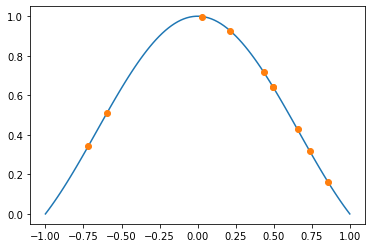

In [2]:
# Generate data set (analogously to qgpr_workflow.ipynb example)
def generate_y(x):
    u = x * np.pi
    return np.sin(u) / u

np.random.seed(42)

# define training and test data
x = np.linspace(-1, 1, 100)
y = generate_y(x)
x_train = np.random.choice(x, 10)
y_train = generate_y(x_train)


plt.plot(x, y)
plt.plot(x_train, y_train, 'o')

In [3]:
# We can define an qml method of choice and use additional scikit-learnfunctions
# to validate the model

# 1. Step: define QML method
# set up feature map with trainable parameters being randomly initialized
# fmap = ChebPQC(num_qubits=4, num_features=1, num_layers=2, seed=42)
feature_map = QEKFeatureMap(num_qubits=4, num_features=1, num_layers=2)
# sample variational parameters of feature map randomly and pass them to kernel definition

executor = Executor('statevector_simulator')

fidelity_kernel = FidelityKernel(feature_map=feature_map, executor=executor, parameter_seed=0)
projected_kernel = ProjectedQuantumKernel(feature_map=feature_map, executor=executor, parameter_seed=0)

In [4]:
# we could also use scikit-learnroutines to optimize hyperparameters
from sklearn.model_selection import GridSearchCV

# parameters = [
#     {'quantum_kernel': [fidelity_kernel], 'num_qubits': [1, 2, 4], 'num_layers': [1, 2]},
#     {'quantum_kernel': [projected_kernel], 'num_qubits': [1, 2, 4], 'num_layers': [1, 2], 'gamma': [ 0.1, 1.0, 10.]}
# ]

parameters = {'num_qubits': [1, 2, 4], 'num_layers': [1, 2]}


qgpr = QGPR(quantum_kernel=fidelity_kernel)#, full_regularization=False)a
grid_search = GridSearchCV(qgpr, parameters)
grid_search.fit(x_train.reshape(-1, 1), y_train)

Regularizing full Gram matrix
Reconstruction error -3.419486915845482e-14
Regularizing full Gram matrix
Reconstruction error 2.19824158875781e-14
Regularizing full Gram matrix
Reconstruction error 2.7977620220553945e-14
Regularizing full Gram matrix
Reconstruction error 7.049916206369744e-15
Regularizing full Gram matrix
Reconstruction error 7.394085344003543e-14
Regularizing full Gram matrix
Reconstruction error -2.8005375796169574e-14
Regularizing full Gram matrix
Reconstruction error 1.0672018824209317e-13
Regularizing full Gram matrix
Reconstruction error 1.2409517857747687e-13
Regularizing full Gram matrix
Reconstruction error 1.3292145162324687e-13
Regularizing full Gram matrix
Reconstruction error 9.889311591848582e-14
Regularizing full Gram matrix
Reconstruction error 1.5376588891058418e-14
Regularizing full Gram matrix
Reconstruction error 5.6066262743570405e-15
Regularizing full Gram matrix
Reconstruction error 4.157785227221211e-14
Regularizing full Gram matrix
Reconstructio

GridSearchCV(estimator=QGPR(quantum_kernel=<squlearn.kernel.matrix.fidelity_kernel.FidelityKernel object at 0x000001C718C281C0>),
             param_grid={'num_layers': [1, 2], 'num_qubits': [1, 2, 4]})

In [5]:
results = grid_search.cv_results_
for i in range(len(results['params'])):
    print("Parameters:", results['params'][i])
    print("Mean Test Score:", results['mean_test_score'][i])
    print("Rank:", results['rank_test_score'][i])
    print("---")

Parameters: {'num_layers': 1, 'num_qubits': 1}
Mean Test Score: 0.7384594458101608
Rank: 6
---
Parameters: {'num_layers': 1, 'num_qubits': 2}
Mean Test Score: 0.799082942202929
Rank: 4
---
Parameters: {'num_layers': 1, 'num_qubits': 4}
Mean Test Score: 0.7999752242697802
Rank: 2
---
Parameters: {'num_layers': 2, 'num_qubits': 1}
Mean Test Score: 0.799888643467336
Rank: 3
---
Parameters: {'num_layers': 2, 'num_qubits': 2}
Mean Test Score: 0.7999801089897844
Rank: 1
---
Parameters: {'num_layers': 2, 'num_qubits': 4}
Mean Test Score: 0.7960568134343202
Rank: 5
---


<AxesSubplot:xlabel='num_layers', ylabel='num_qubits'>

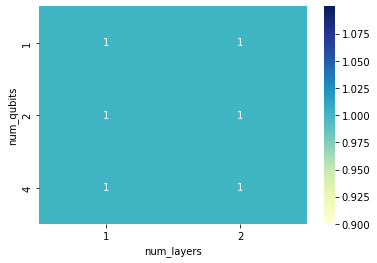

In [ ]:
# Convert results to DataFrame
df = pd.DataFrame(results['params'])
df['score'] = results['mean_test_score']

# Pivot with aggregation to handle duplicates
heatmap_data = df.pivot_table(index='num_qubits', columns='num_layers', values='score', aggfunc='mean')

# Plot heatmap
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")


In [ ]:

# 2. Step load and use additional scikit-learn routines
from sklearn.model_selection import cross_val_score, cross_val_predict
                                                 
print("Cross validation score:", cross_val_score(QSVR, x_train.reshape(-1, 1), y_train, cv=5))
print(
    "Cross validation prediction:",
    cross_val_predict(qsvr_fqk, x_train.reshape(-1, 1), y_train, cv=5))

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [ ]:
qsvr_grid.fit(x_train.reshape(-1, 1), y_train)

c:\Users\mcr\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
75 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mcr\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
AttributeError: 'NoneType' object has no attribute 'fit'

  warnings.warn(some_fits_failed_message, FitFailedWarning)
c:\Users\mcr\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan na

TypeError: Cannot clone object 'None' (type <class 'NoneType'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [ ]:
from sklearn.metrics import mean_squared_error as mse

print("Best parameters:", qsvr_grid.best_params_)
print(
    "MSE with optimized hyperparameters:", mse(y_train, qsvr_grid.predict(x_train.reshape(-1, 1)))
)

Best parameters: {'C': 0.001, 'epsilon': 0.01}


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc = SVC()
grid_search = GridSearchCV(svc, parameters)

In [ ]:
from squlearn.kernel import QSVC

QSVC(quantum_kernel=None)

AttributeError: 'NoneType' object has no attribute 'get_params'